In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR


In [8]:
# Chargement  des données
import pandas as pd
data = pd.read_csv('/content/drive/MyDrive/donnees_macro.csv')


In [10]:
## Affichage

print(data.head())

         Date          PIB  Taux_interet  Inflation
0  2000-03-31  1010.993428      4.584049   1.031767
1  2000-06-30  1020.716900      1.621815   2.639936
2  2000-09-30  1032.012277      2.346723   3.268889
3  2000-12-31  1045.058336      3.899980   2.220803
4  2001-03-31  1054.590030      1.529592   2.118602


In [18]:
print(data.columns)


Index(['Date', 'PIB', 'Taux_interet', 'Inflation'], dtype='object')


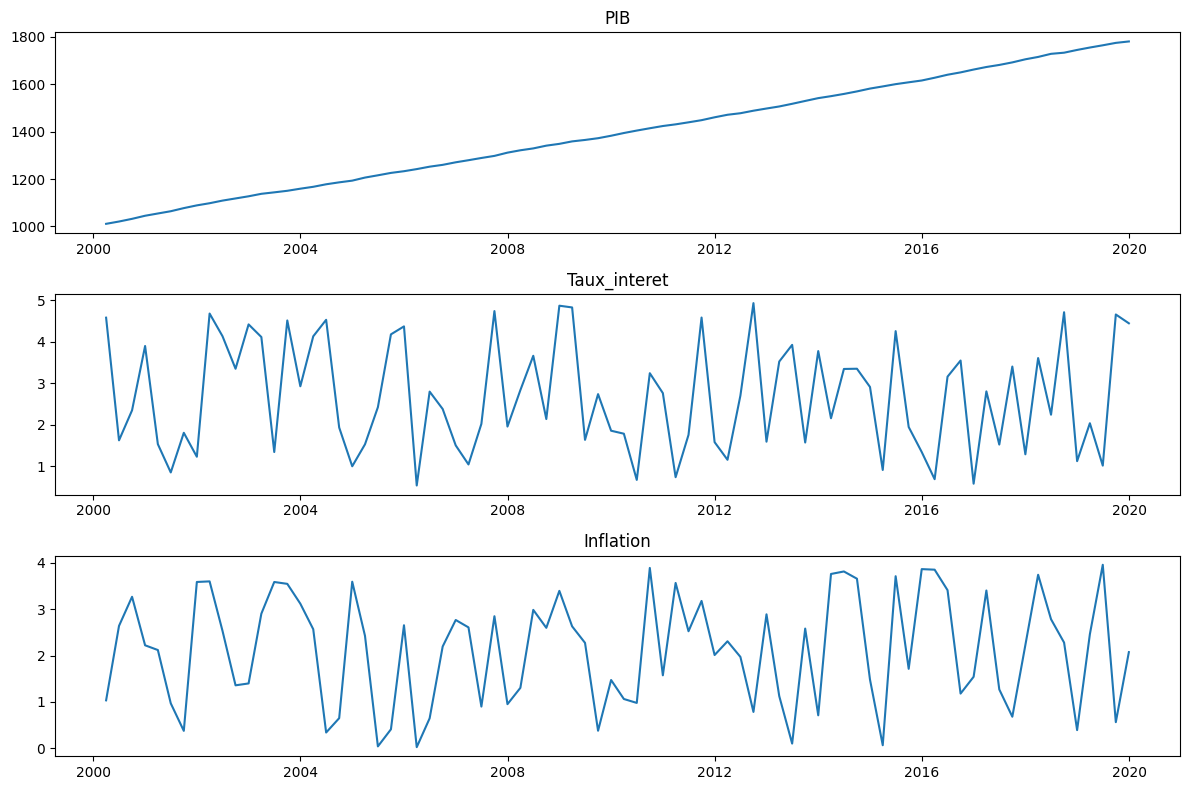

In [21]:
# Visualisation des séries temporelles

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Convertir les dates en datetime si nécessaire
data['Date'] = pd.to_datetime(data['Date'])

# Visualisation des séries temporelles
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(data['Date'], data['PIB'])
plt.title('PIB')

plt.subplot(3, 1, 2)
plt.plot(data['Date'], data['Taux_interet'])
plt.title('Taux_interet')

plt.subplot(3, 1, 3)
plt.plot(data['Date'], data['Inflation'])
plt.title('Inflation')

plt.tight_layout()
plt.show()


In [24]:
## Vérification de la stationnarité

## Test de Dickey-Fuller Augmenté pour chaque série

def adf_test(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print(f"Critical Values: {result[4]}")
    print("-" * 40)

# Tester chaque série
adf_test(data['PIB'])
adf_test(data['Taux_interet'])
adf_test(data['Inflation'])


ADF Statistic: 2.8779007384428166
p-value: 1.0
Critical Values: {'1%': -3.528889992207215, '5%': -2.9044395987933362, '10%': -2.589655654274312}
----------------------------------------
ADF Statistic: -9.207457885561569
p-value: 1.9276326815671945e-15
Critical Values: {'1%': -3.5159766913976376, '5%': -2.898885703483903, '10%': -2.5866935058484217}
----------------------------------------
ADF Statistic: -8.007645180529341
p-value: 2.2452024394141916e-12
Critical Values: {'1%': -3.5159766913976376, '5%': -2.898885703483903, '10%': -2.5866935058484217}
----------------------------------------


In [25]:
##  Comme e p-value du test ADF est supérieur à 0.05, cela signifie que la série n'est pas stationnaire.


In [28]:
## Appliquer de la différenciation

data['PIB_diff'] = data['PIB'].diff().dropna()
data['Taux_d_interet_diff'] = data['Taux_interet'].diff().dropna()
data['Inflation_diff'] = data['Inflation'].diff().dropna()


In [30]:
## Extimation du nombre optimal de retards en utilisant AIC et BIC

model = VAR(data[['PIB', 'Taux_interet', 'Inflation']])
lag_order = model.select_order()
print(lag_order.summary())


 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        11.52       11.62   1.011e+05       11.56
1       2.410*      2.798*      11.14*      2.564*
2        2.521       3.200       12.46       2.790
3        2.695       3.666       14.89       3.080
4        2.814       4.077       16.91       3.315
5        2.976       4.531       20.13       3.593
6        3.043       4.888       21.90       3.775
7        3.071       5.207       23.09       3.918
8        3.216       5.644       27.65       4.180
9        3.339       6.059       32.72       4.418
10       3.481       6.492       39.98       4.676
11       3.330       6.633       37.04       4.641
--------------------------------------------------


In [32]:
## Estimer le modèle VAR avec le nombre de retards optimal

var_model = model.fit(lag_order.aic)  # Utilise l'ordre qui minimise AIC
print(var_model.summary())


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 03, Mar, 2025
Time:                     11:24:22
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    2.72655
Nobs:                     79.0000    HQIC:                   2.51083
Log likelihood:          -417.770    FPE:                    10.6642
AIC:                      2.36663    Det(Omega_mle):         9.19551
--------------------------------------------------------------------
Results for equation PIB
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                   9.291534         1.551928            5.987           0.000
L1.PIB                  1.000275         0.001006          994.211           0.000
L1.Taux_interet        -0.065373         0.167071     

In [34]:
## Vérification de  la stabilité du modèle

if np.max(np.abs(var_model.roots)) < 1:
    print("Le modèle est stable.")
else:
    print("Le modèle n'est pas stable.")


Le modèle n'est pas stable.


In [37]:
## Teste de  l’autocorrélation des résidus

from statsmodels.stats.diagnostic import acorr_ljungbox

# Test de Ljung-Box
lb_test = acorr_ljungbox(var_model.resid.iloc[:, 0], lags=[lag_order.aic])
print(lb_test)


    lb_stat  lb_pvalue
1  0.063661   0.800801


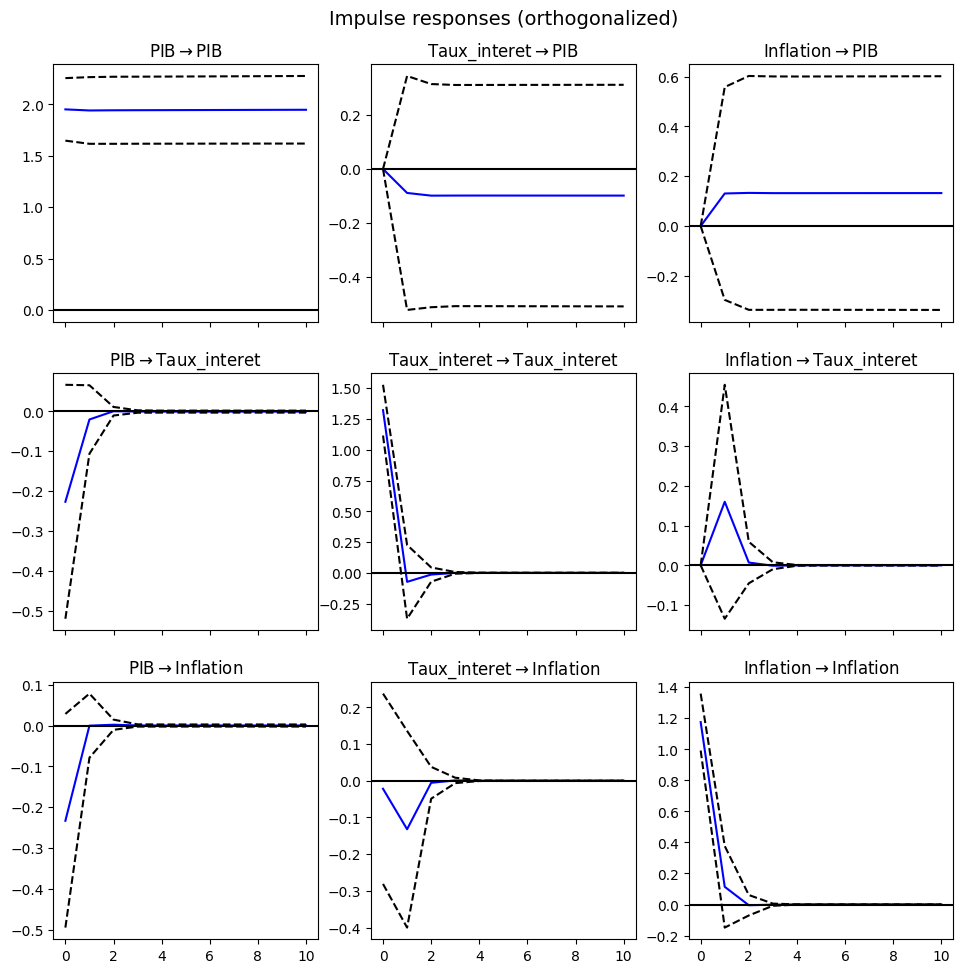

In [39]:
##  Analyse dynamique des résultats

## Tracer les fonctions de réponse impulsionnelle (IRF)

irf = var_model.irf(10)
irf.plot(orth=True)
plt.show()


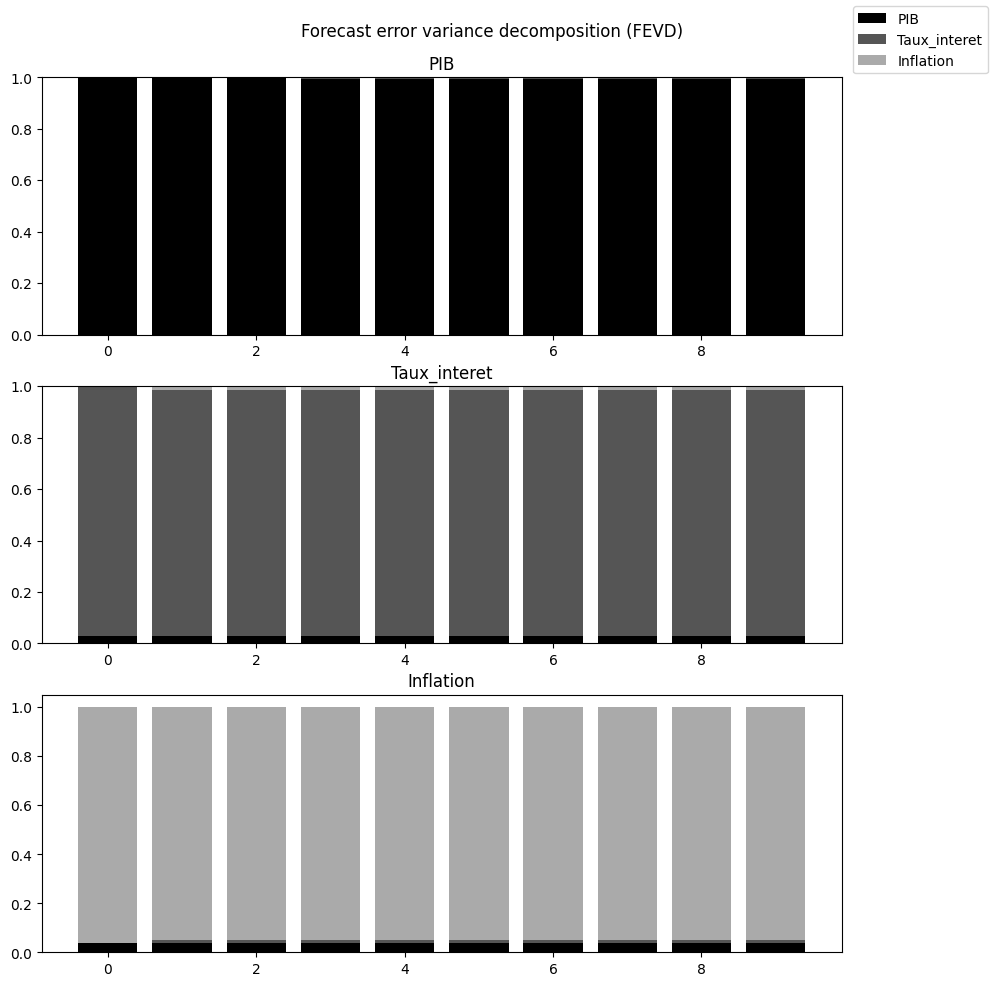

In [41]:
## Analyse de  la décomposition de la variance des erreurs de prévision

fevd = var_model.fevd(10)  # Décomposition sur 10 périodes
fevd.plot()
plt.show()


In [ ]:
## Reponse de la question 6

#   1) Quelle variable influence le plus les autres dans le modèle VAR ?
##     Le PIB semble être la variable qui influence le plus les autres.
##     Les coefficients montrent que le PIB a un effet fort sur lui-même,
##     tandis que les autres variables (taux d’intérêt et inflation)
##     ont un impact faible et non significatif sur le PIB et l’inflation.



##  2) Quel est l’effet d’un choc sur le taux d’intérêt sur le PIB et l’inflation ?
##     Le taux d’intérêt a un effet faible et non significatif sur le PIB et
##     l’inflation à court terme, ce qui suggère qu’un choc sur le taux n’a pas un impact
##     immédiat sur ces deux variables dans ce modèle.



##  3) Que suggèrent ces résultats en termes de politique monétaire et économique ?
##     Les résultats montrent que le taux d’intérêt n'a pas un effet immédiat significatif sur le PIB
##     ou l’inflation.
##     Cela pourrait indiquer que la politique monétaire actuelle n'a pas un impact direct à court terme,
##     et qu'une approche plus ciblée pourrait être nécessaire.